Title

### Introduction 

**Question**: How well can we use a patient’s glucose and insulin levels to predict if someone has type 2 diabetes?

**Dataset Information**: The dataset we will be manipulating involves the data for type 2 diabetic cases for female Pima Indian Heritage patients of 20 years of age and over. It has various columns including the number of pregnancies (number of times pregnant), glucose levels in the blood (plasma glucose concentration: results of a 2 hour oral glucose tolerance test), blood pressure (diastolic blood pressure (mm Hg), the thickness of the skin (triceps skin fold thickness (mm)), insulin levels in the blood (2-hour serum insulin (mu U/mL), body mass index (BMI) (weight in kg/(height in m)^2), diabetes pedigree function (likelihood of getting type 2 diabetes), age (years) and class variable which is either 1 (has type 2 diabetes) or 0 (doesn’t have type 2 diabetes). 

### Methods & Results

First, we need to load the libraries which contain each function we use for data analysis into the notebook. We use tidyverse for basic data wrangling functions, repr to control the look of our visualizations, and tidymodels to do the classification part of the data analysis. 

In [1]:
# loading necessary libraries 
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Now we need to load the in the data using a URL so that it is easier for others to access as well. 

In [45]:
# loading the data from a url and modifying the double Outcome to become a factor datatype 
diabetes <- read_csv("https://raw.githubusercontent.com/kzhang1223/dsci-100-2023s1-group-55/main/diabetes.csv") |>
        mutate(Outcome = as_factor(Outcome)) 
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


Here we tidy up the data by selecting only the columns we will be using for the data analysis which are glucose levels, insulin levels and the diagnosis of type 2 diabetes. Additionally, we also filter out any zeroes in the Glucose and Insulin column because they represent missing values. 

In [ ]:
# selecting only the columns we will use for the data analysis, which are blood pressure, BMI and the diagnosis
diabetes_clean <- diabetes |>
    select(BloodPressure, BMI, Outcome) 

# removing any zeroes from the blood pressure and BMI column as they represent missing data 
diabetes_no_zeroes <- diabetes |>
    filter(Glucose != 0 & Insulin != 0) 
head(diabetes_no_zeroes)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
3,78,50,32,88,31.0,0.248,26,1
2,197,70,45,543,30.5,0.158,53,1
1,189,60,23,846,30.1,0.398,59,1
5,166,72,19,175,25.8,0.587,51,1


Next, we will create a scatterplot to see the relationship between the two predictors we are using for the data analysis.

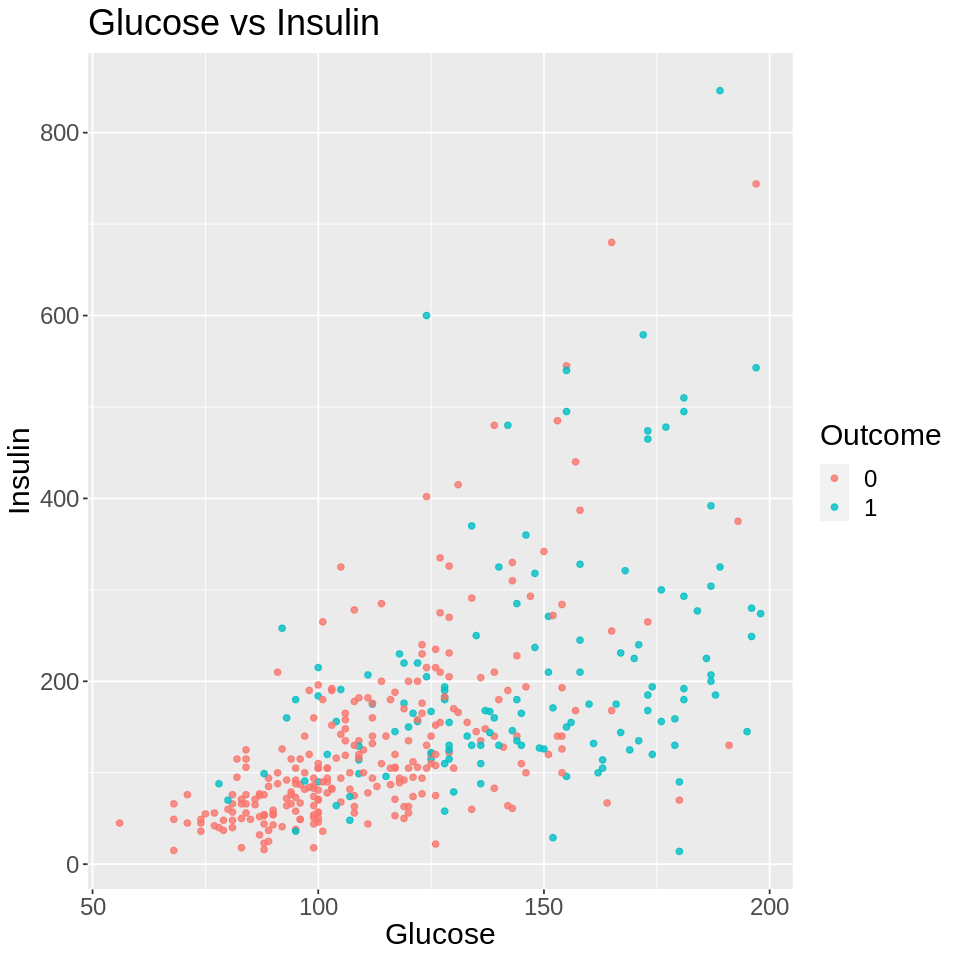

In [18]:
# creating a scatterplot of blood pressure vs BMI with all the data, colouring by the diagnosis of type 2 diabetes
options(repr.plot.width = 8, repr.plot.height = 8)

diabetes_plot <- diabetes_no_zeroes |>
    ggplot(aes(x = Glucose, y = Insulin, colour = Outcome)) +
    geom_point(alpha = 0.8) +
    theme(text = element_text(size = 18)) + 
    ggtitle("Glucose vs Insulin") + 
    scale_fill_brewer(palette = 'Set2')

diabetes_plot

Now we will conduct the data analysis. 

In [31]:
# setting the seed 
set.seed(5) 

# splitting the data into training and testing sets where 75% of the data goes into the training set 
diabetes_split <- initial_split(diabetes_no_zeroes, prop = 0.75, strata = Outcome)
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split) 

# preprocessing the data and creating the recipe 

diabetes_recipe <- recipe(Outcome ~ Glucose + Insulin, data = diabetes_training)|>
step_scale(all_predictors()) |>
step_center(all_predictors())

# setting the model specification with tune() to find the best k value for this model 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

# creating the cross validation sets 

diabetes_vfold <- vfold_cv(diabetes_training, v = 7, strata = Outcome)


# creating the values of k we will use 

kvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))



In [41]:
# fitting the model to the validation sets 

diabetes_fit <- workflow() |>
add_recipe(diabetes_recipe)|>
add_model(knn_spec) |>
tune_grid(resamples = diabetes_vfold, grid = kvals) |>
collect_metrics()

# filtering for only accuracy 
accuracies <- diabetes_fit |>
filter(.metric == "accuracy")
accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6768958,7,0.016118524,Preprocessor1_Model01
6,accuracy,binary,0.7415333,7,0.014898864,Preprocessor1_Model02
11,accuracy,binary,0.7416162,7,0.017975174,Preprocessor1_Model03
16,accuracy,binary,0.7415333,7,0.010676912,Preprocessor1_Model04
21,accuracy,binary,0.7483360,7,0.011201900,Preprocessor1_Model05
26,accuracy,binary,0.7585439,7,0.009347740,Preprocessor1_Model06
31,accuracy,binary,0.7652675,7,0.020446749,Preprocessor1_Model07
36,accuracy,binary,0.7652675,7,0.012170469,Preprocessor1_Model08
41,accuracy,binary,0.7617832,7,0.009482953,Preprocessor1_Model09


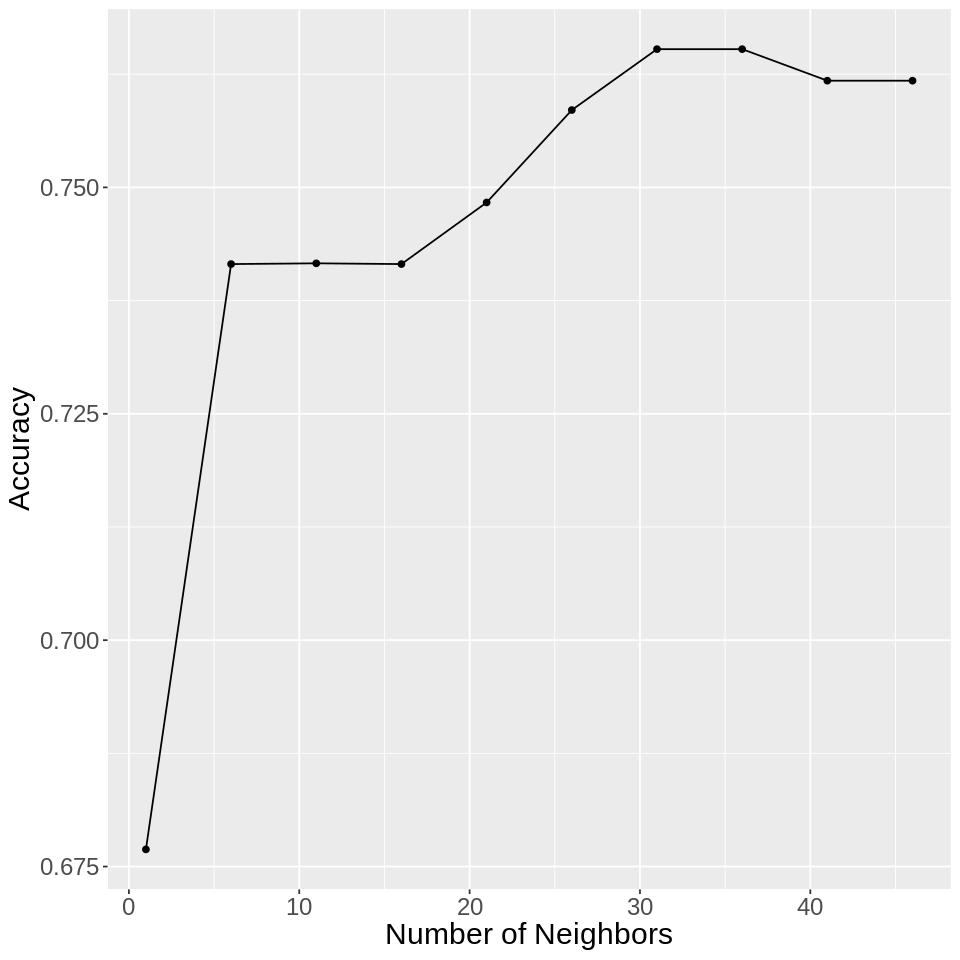

In [33]:
# plotting the results to determine the best k value 

best_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy")  +
    theme(text = element_text(size = 18))

best_k

In [42]:
# recreating the model specification with the best value of k

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
    set_engine("kknn") |>
    set_mode("classification")

# using the same recipe and folds from before to fit the model

diabetes_fit <- workflow() |>
    add_recipe(diabetes_recipe)|>
    add_model(best_spec) |>
    fit(data = diabetes_training) 

# predicting the test data outcomes
predict_diabetes <- predict(diabetes_fit, diabetes_testing) |>
    bind_cols(diabetes_testing)

# calculating the accuracy for the predictions
final_accuracy <- predict_diabetes |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
final_accuracy

# confusion matrix for the predictions
diabetes_conf_mat <- predict_diabetes |>
    conf_mat(truth = Outcome, estimate = .pred_class)
diabetes_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7373737


          Truth
Prediction  0  1
         0 56 16
         1 10 17

Discussion 

References